In [37]:
#### scientific libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from skimage import io
import pandas as pd
import seaborn as sns

# general libraries
import os  
import sys
import json
import time
import h5py as h5
from functools import partial

# local libraries
from analysis import *
from general_utils import *
from hdf_utils import unpack_hdf, Workspace
from scalebars import *
import deconv

# import balance_configs as configs
import sac_mode_configs as configs
import experiments as exps
import analysis as ana
sys.path.append('../imaging-utils')
from image_arrays import map_axis

In [2]:
# %matplotlib notebook
%matplotlib widget
plt.rcParams.update({"figure.max_open_warning": 0})
plt.rcParams['svg.fonttype'] = 'none'  # don't save font as paths (assumes font present on machine)

In [3]:
base_path = ""
exts = [".png", ".svg"]
bmb_green = "#009800ff"
bmb_magenta = "#fe36d0ff"

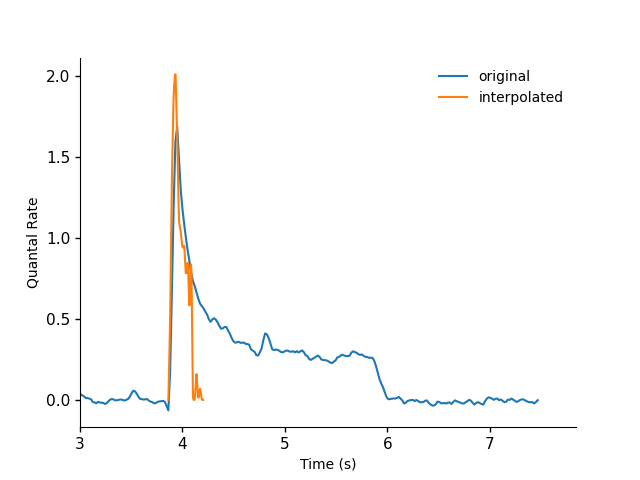

In [4]:
quanta_h5 = "quantum_pack.h5"
with h5.File(quanta_h5, "r") as f:
    quantum_pack = unpack_hdf(f)
    
release_rates = quantum_pack["clipped_rates"]
rec_dt = quantum_pack["rec_dt"]
target_rate_dt = 0.005  # 0.0001
bp_inputs = {("sust" if k == "PD" else "trans"): r for k, r in quantum_pack["aligned_recs"].items()}
bp_inputs["sust"] = bp_inputs["sust"] * np.max(bp_inputs["trans"]) / np.max(bp_inputs["sust"])

vrate = deconv.velocity_rate(
    bp_inputs["trans"],
    rec_dt,
    quantum_pack["quantum"],
    1,
    rf=0.06,
    spot=0.2,
    bsln_start=100,
    bsln_end=150,
    step=1,
    offset=0.,
    model_dt=target_rate_dt,
)
vrate = np.clip(vrate, 0.0, np.inf)

trans_rise = find_rise_bsln(bp_inputs["trans"], bsln_start=100, bsln_end=150, step=1) * rec_dt
rate_fig, rate_ax = plt.subplots(1)
rate_ax.plot(np.arange(len(bp_inputs["trans"])) * rec_dt, bp_inputs["trans"], label="original")
rate_ax.plot(np.arange(len(vrate)) * target_rate_dt + trans_rise, vrate, label="interpolated")
rate_ax.set_xlim(3)
rate_ax.set_xlabel("Time (s)")
rate_ax.set_ylabel("Quantal Rate")
rate_ax.legend(frameon=False)
clean_axes(rate_ax)

In [5]:
model_path = os.path.join(base_path, "vc_param_runs")
fig_dir_path = os.path.join(model_path, "figs") 
overwrite = False

save_name = "test"
load_name = None

model_config = configs.thesis(
    vc_mode="sealed",
    non_ds_ach=False,
    offset_ampa_ach=False,
    record_tree=False,
    poisson_rates={"sac": vrate / np.max(vrate), "glut": vrate / np.max(vrate), "dt": target_rate_dt},
    plexus=0,
    plexus_share=None,
    stacked_plex=False,
)

n_nets = 9
n_trials = 5
rho_steps = [0.0, 1.0]
pool_sz = 6

param_paths = [
    ["synprops", "E", "pref_prob"], 
    ["synprops", "PLEX", "pref_prob"],
    ["synprops", "I", "pref_prob"], 
    ["synprops", "AMPA", "pref_prob"], 
    ["synprops", "AMPA", "null_prob"], 
    ["synprops", "NMDA", "pref_prob"], 
    ["synprops", "NMDA", "null_prob"], 
]

ratio_steps = [1, 1 / 1.333, 1 / 1.45, 0.5]
ach_steps = ratio_steps
ampa_steps = list((1 - np.array(ratio_steps)) / 2)
gaba_steps = [1, 1, 1, 1]
nmda_steps = [1, 1, 1, 1]

param_steps = [
    ach_steps,
    ach_steps,
    gaba_steps,
    ampa_steps,
    ampa_steps,
    nmda_steps,
    nmda_steps,
]
# step_lbls = [1.0, 2.5, 3.0]
step_lbls = ach_steps
step_lbls = list(np.array(ach_steps).round(decimals=2))
step_lbls = list(np.array(ratio_steps).round(decimals=2))

save_path = os.path.join(model_path, save_name) + ".h5"
if load_name is None:
    load_name = save_name
    if (not overwrite and os.path.exists(save_path)):
        print(
            "Loading %s rather than overwriting it.\nSet `overwrite = True` if saving over is desired."
            % save_name
        )
    else:
        from ei_balance_nogui import *
        os.makedirs(model_path, exist_ok=True)
        save_path = os.path.join(model_path, save_name) + ".h5"
        load_name = save_name
        t0 = time.time()
        exps.sacnet_param_run(
            save_path,
            model_config,
            param_paths,
            param_steps,
            step_lbls,
            n_nets=n_nets,
            n_trials=n_trials,
            rho_steps=rho_steps,
            pool_sz=pool_sz,
            vc_mode=True,
            vc_isolate=True,
            reset_seed_between_rho=True,
        )
            
        print("parameter run time:", time.time() - t0)

hdf = h5.File(os.path.join(model_path, load_name) + ".h5", "r")
d = Workspace(hdf, read_only=True)
fig_path = os.path.join(fig_dir_path, load_name)
os.makedirs(fig_path, exist_ok=True)

param_paths = [d["run_params"]["paths"][i][:] for i in d["run_params"]["paths"].keys()]
param_steps = [d["run_params"]["steps"][i][:] for i in d["run_params"]["steps"].keys()]
step_lbls = d["run_params"]["step_lbls"][:]
n_steps = len(step_lbls)
step_idxs = list(range(n_steps))
rhos = list(d[step_lbls[0]].keys())
idxs = list(d[step_lbls[0]][rhos[0]].keys())
exp_keys = list(d[step_lbls[0]][rhos[0]][idxs[0]].keys())
transmitters = list(d[step_lbls[0]][rhos[0]][idxs[0]]["soma"].keys())
n_trials, n_dirs, n_steps = d[step_lbls[0]][rhos[0]][idxs[0]]["soma"]["E"].shape
print("==keys==")
print("step_idxs:", step_idxs)
print("step_lbls:", step_lbls)
print("rhos:", rhos)
print("idxs:", idxs)
print("exp keys:", exp_keys)
print("rec keys:", transmitters)
print("rec shape:", (n_trials, n_dirs, n_steps))

Loading locked_total_e_slow_ampa rather than overwriting it.
Set `overwrite = True` if saving over is desired.
==keys==
step_idxs: [0, 1, 2, 3]
step_lbls: [1.   0.75 0.69 0.5 ]
rhos: [0.0, 1.0]
idxs: [0, 1, 2, 3, 4, 5, 6, 7, 8]
exp keys: ['params', 'sac_net', 'soma', 'syn_locs']
rec keys: ['ACH', 'AMPA', 'E', 'GABA', 'NMDA']
rec shape: (5, 8, 7501)


In [6]:
params = d[step_lbls[0]][0.0][0]["params"]
dir_labels = params["dir_labels"][:]
dt = params["dt"]
null_idx = np.argwhere(dir_labels == 180)[0][0]
pref_idx = np.argwhere(dir_labels == 0)[0][0]
xaxis = np.arange(int(params["tstop"] / params["dt"]) + 1) * params["dt"]
bsln_start = nearest_index(xaxis, 30)
bsln_end = nearest_index(xaxis, 35)

In [7]:
def trans_maxima(trans, rec, flip=False, **kwargs):
    gaba = trans == "GABA"
    mx = not gaba if flip else gaba  
    f = np.max if mx else np.min
    return f(rec[..., int(15 / dt):], **kwargs)
    
vc_recs = {
    s: {
        rho: {
            n: {
                trans: rec - trans_maxima(trans, rec, flip=True, axis=-1, keepdims=True) 
                for trans, rec in net["soma"].items()
            }
            for n, net in nets.items()
        }
        for rho, nets in d[s].items()
    }
    for s in step_lbls
}

if "NMDA" in transmitters:
    for s in step_lbls:
        for rho in rhos:
            for n in idxs:
                vc_recs[s][rho][n]["NMDA"] -= vc_recs[s][rho][n]["NMDA"][:, :, bsln_start:bsln_end].mean()

vc_peaks = mapi_data(partial(trans_maxima, axis=-1), vc_recs)
vc_trial_avgs = map_data(partial(np.mean, axis=0), vc_recs)
vc_trial_avg_peaks = mapi_data(partial(trans_maxima, axis=-1), vc_trial_avgs)
vc_net_avgs = {
    s: {
        rho: {
            trans: np.mean([net[trans] for net in nets.values()], axis=0)
            for trans in transmitters
        }
        for rho, nets in rs.items()
    }
    for s, rs in vc_trial_avgs.items()
}
vc_net_avg_peaks = mapi_data(partial(trans_maxima, axis=-1), vc_net_avgs)

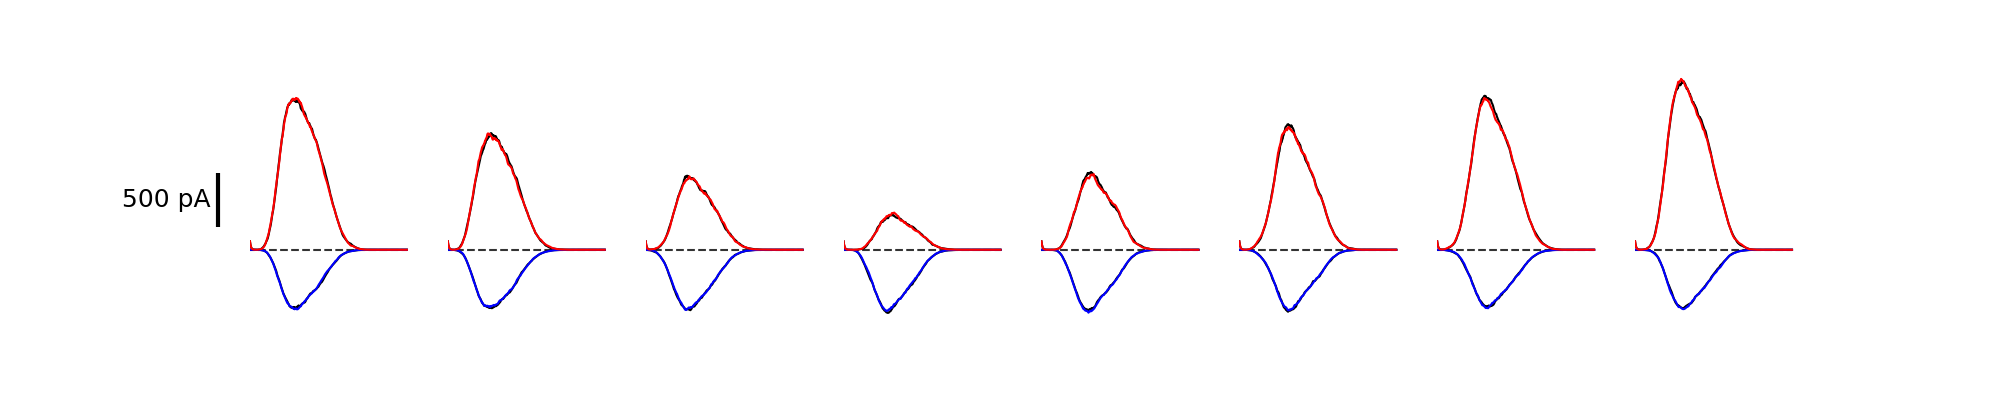

In [8]:
incl_rho0 = True
incl_nmda = False
display_step = step_lbls[0]

net_avg_fig, net_avg_ax = plt.subplots(
    1, len(dir_labels), sharex=True, sharey="row", figsize=(20, 4))

for i, ax in enumerate(net_avg_ax):
    ax.plot([xaxis[0], xaxis[-1]], [0., 0.], c="black", linestyle="--", alpha=0.8)
    if incl_rho0:
        ax.plot(xaxis, vc_net_avgs[display_step][0.0]["E"][i], c="black")
        ax.plot(xaxis, vc_net_avgs[display_step][0.0]["GABA"][i], c="black")
    ax.plot(xaxis, vc_net_avgs[display_step][1.0]["E"][i], c="blue")
    ax.plot(xaxis, vc_net_avgs[display_step][1.0]["GABA"][i], c="red")
    if incl_nmda and "NMDA" in vc_net_avgs[display_step][1.0]:
        ax.plot(xaxis, vc_net_avgs[display_step][1.0]["NMDA"][i], c="green")

clean_axes(net_avg_ax, remove_spines=["left", "right", "top", "bottom"])

add_scalebar(
    net_avg_ax[0], 
    matchx=False, 
    matchy=False, 
    # sizey=1.5, 
    # labely="1.5 nA",
    sizey=0.5, 
    labely="500 pA",
    sep=5,
    barwidth=3,
    loc="center",
    bbox_to_anchor=(170, 200),
    textprops={"fontsize": 18},
)

# net_avg_ax[-1].set_ylim(-2, 4)
net_avg_ax[-1].set_ylim(-1, 1.9)
# net_avg_ax[-1].set_ylim(-2, 6)
# net_avg_ax[-1].set_xlim(10, 300)
net_avg_ax[-1].set_xlim(15)
rho0_lbl = "_w_rho0" if incl_rho0 else ""
nmda_lbl = "_+nmda" if incl_nmda else ""
name = os.path.join(fig_path, "contrast_%s_net_avg_ach_gaba%s%s.svg" % (str(display_step), rho0_lbl, nmda_lbl))
net_avg_fig.savefig(name)

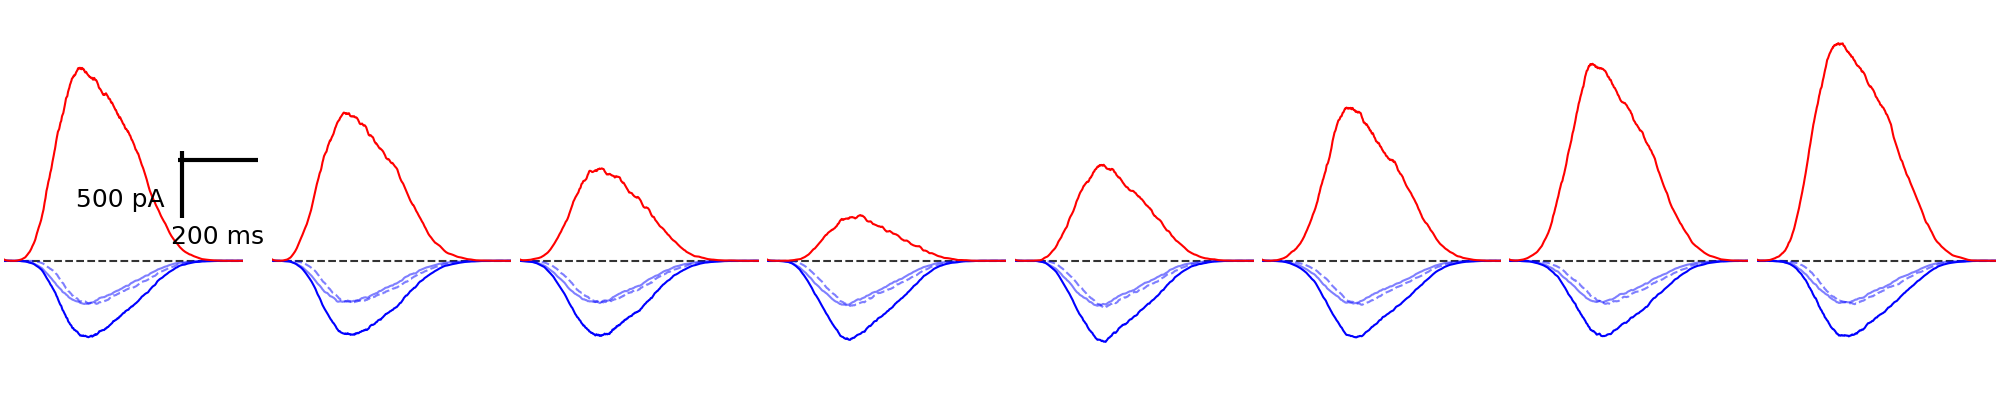

In [9]:
incl_nmda = False
incl_ach = True
incl_ampa = True

display_step = step_lbls[-1]

net_avg_fig, net_avg_ax = plt.subplots(
    1, len(dir_labels), sharex=True, sharey="row", figsize=(20, 4))

for i, ax in enumerate(net_avg_ax):
    ax.plot([xaxis[0], xaxis[-1]], [0., 0.], c="black", linestyle="--", alpha=0.8)
    ax.plot(xaxis, vc_net_avgs[display_step][1.0]["E"][i], c="blue")
    if incl_ach:
        ax.plot(xaxis, vc_net_avgs[display_step][1.0]["ACH"][i], c="blue", alpha=0.5, ls="-")
    if incl_ampa:
        ax.plot(xaxis, vc_net_avgs[display_step][1.0]["AMPA"][i], c="blue", alpha=0.5, ls="--")
    ax.plot(xaxis, vc_net_avgs[display_step][1.0]["GABA"][i], c="red")
    if incl_nmda and "NMDA" in vc_net_avgs[display_step][1.0]:
        ax.plot(xaxis, vc_net_avgs[display_step][1.0]["NMDA"][i], c="green")

clean_axes(net_avg_ax, remove_spines=["left", "right", "top", "bottom"])

add_scalebar(
    net_avg_ax[0], 
    matchx=False, 
    matchy=False, 
    # sizey=1.5, 
    # labely="1.5 nA",
    sizey=0.5, 
    labely="500 pA",
    sizex=200,
    labelx="200 ms",
    sep=5,
    barwidth=3,
    loc="center",
    bbox_to_anchor=(170, 200),
    textprops={"fontsize": 18},
)

# net_avg_ax[-1].set_ylim(-2, 4)
net_avg_ax[-1].set_ylim(-1, 1.9)
# net_avg_ax[-1].set_ylim(-2, 6)
# net_avg_ax[-1].set_xlim(10, 300)
net_avg_ax[-1].set_xlim(25, 620)

net_avg_fig.set_layout_engine("compressed")

nmda_lbl = "_+nmda" if incl_nmda else ""
name = os.path.join(fig_path, "contrast_%s_net_avg_EI%s.svg" % (str(display_step), nmda_lbl))
net_avg_fig.savefig(name)

In [10]:
# fff, aaa = plt.subplots(1)
# aaa.plot(xaxis, vc_net_avgs[1.0]["E"][pref_idx], c="blue")
# aaa.plot(xaxis, vc_net_avgs[1.0]["NMDA"][pref_idx], c="green")

In [11]:
display_step = step_lbls[0]
upward_e_avgs = vc_net_avgs[display_step][1.00]["E"] * -1
time_offsets = np.array([
    find_rise_bsln(d, bsln_start=0, bsln_end=1, offset=0.03, step=1)
    for d in upward_e_avgs
]) * params["dt"]
align_offsets = np.max(time_offsets) - time_offsets

print("E field offsets (ms):", time_offsets)
print("alignment_shifts (ms):", align_offsets)

E field offsets (ms): [ 96.1  82.1  68.1  84.4 100.4  94.3 100.8 101.9]
alignment_shifts (ms): [ 5.8 19.8 33.8 17.5  1.5  7.6  1.1  0. ]


Text(0.5, 0, 'Time (ms)')

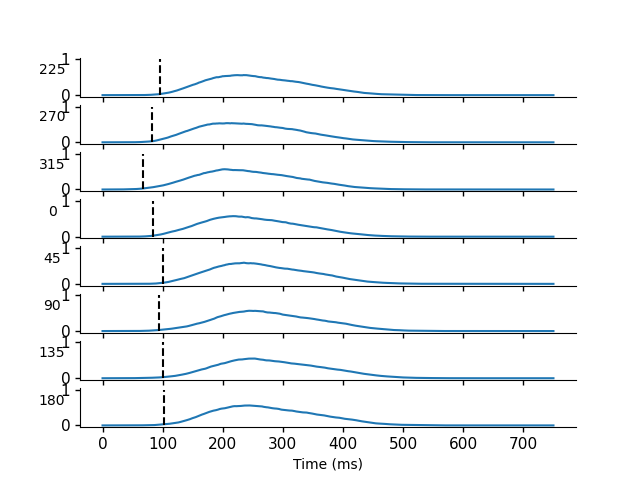

In [12]:
rf_offset_fig, rf_offset_ax = plt.subplots(8)
for ax, dr, avg, off in zip(rf_offset_ax, dir_labels, upward_e_avgs, time_offsets):
    ax.plot(xaxis, avg)
    ax.plot([off, off], [0, 1], linestyle="--", c="black")
    ax.set_ylabel(dr, rotation="horizontal", labelpad=6., position=(1, 0.3))
    
clean_axes(rf_offset_ax)
rf_offset_ax[-1].set_xlabel("Time (ms)")

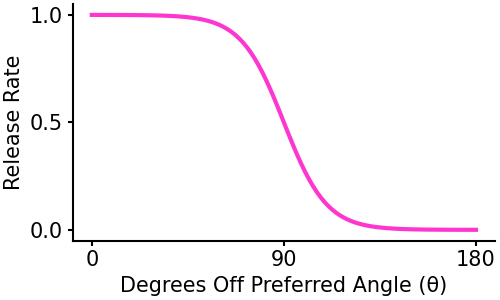

In [13]:
def sigmoid (d, n, p, offset=90, slope=0.075): 
    return p + (n - p) * (1 - 1 / (1 + np.exp((d - offset) * slope)))

# null_pr = 0.05
# pref_pr = 0.95
null_pr = 0.0
pref_pr = 1.0

dir_range = np.linspace(0, 180, 100) 
prob_p1 = np.squeeze(sigmoid(dir_range, null_pr, pref_pr, offset=90, slope=0.1))
prob_p075 = np.squeeze(sigmoid(dir_range, null_pr, pref_pr))
prob_p05 = np.squeeze(sigmoid(dir_range, null_pr, pref_pr, slope=null_pr))

sigmoid_fig, sigmoid_ax = plt.subplots(1, figsize=(5, 3))
sigmoid_ax.plot(dir_range, prob_p1, c=bmb_magenta, linewidth=3, label="slope 0.1")
# sigmoid_ax.plot(dir_range, prob_p075, linewidth=3, label="slope 0.075")
# sigmoid_ax.plot(dir_range, prob_p05, linewidth=3, label="slope 0.05")
sigmoid_ax.set_ylabel("Release Rate", fontsize=15)
sigmoid_ax.set_xlabel("Degrees Off Preferred Angle (θ)", fontsize=15)
sigmoid_ax.set_yticks([0, 0.5, 1])
sigmoid_ax.set_xticks([0, 90, 180])
clean_axes(sigmoid_ax, ticksize=15, spine_width=1.5)
# sigmoid_fig.legend()
sigmoid_fig.set_layout_engine("compressed")
sigmoid_fig.savefig(os.path.join(fig_path, "prob_sigmoid.svg"), bbox_inches="tight")

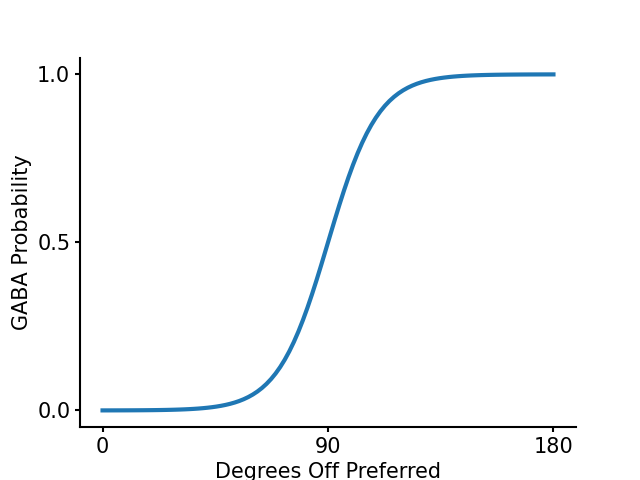

In [14]:
gaba_sigmoid_fig, gaba_sigmoid_ax = plt.subplots(1)
gaba_sigmoid_ax.plot(180 - dir_range, prob_p1, linewidth=3)
gaba_sigmoid_ax.set_ylabel("GABA Probability", fontsize=15)
gaba_sigmoid_ax.set_xlabel("Degrees Off Preferred", fontsize=15)
clean_axes(gaba_sigmoid_ax, ticksize=15)
gaba_sigmoid_ax.set_yticks([0, 0.5, 1])
gaba_sigmoid_ax.set_xticks([0, 90, 180])
clean_axes(gaba_sigmoid_ax, ticksize=15, spine_width=1.5, tick_width=1.5)
gaba_sigmoid_fig.savefig(os.path.join(fig_path, "gaba_sigmoid.svg"), bbox_inches="tight")

In [15]:
res_e = "E"
res_i = "GABA"
start_t = 0  # ms
start_idx = nearest_index(xaxis, start_t)
res_xaxis = xaxis[start_idx:]
residuals = {
    s: {
        rho: {
            net: {
                k: vc_recs[s][rho][net][k][:, :, start_idx:] - vc_trial_avgs[s][rho][net][k][:, start_idx:]
                for k in [res_e, res_i] 
            }
            for net in idxs
        }
        for rho in vc_trial_avgs[s].keys()
    }
    for s in step_lbls
}

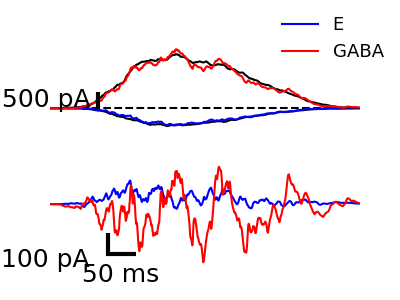

In [16]:
step = step_lbls[0]
rho = 0.0
net = 0
trial = 0
angle = 180
normalize_resid = False
invert_i = False
scalebar_mode = True
dir_idx = np.argwhere(dir_labels == angle)[0][0]

residual_ex_fig, residual_ex_ax = plt.subplots(
    2,
    sharex=True,
    figsize=(4, 3),
)

residual_ex_ax[0].plot([np.min(xaxis), np.max(xaxis)], [0, 0], c="black", linestyle="--")
residual_ex_ax[0].plot(xaxis, vc_trial_avgs[step][rho][net][res_e][dir_idx], c="black")
residual_ex_ax[0].plot(xaxis, vc_recs[step][rho][net][res_e][trial, dir_idx], c="blue", label=res_e)
residual_ex_ax[0].plot(xaxis, vc_trial_avgs[step][rho][net][res_i][dir_idx], c="black")
residual_ex_ax[0].plot(xaxis, vc_recs[step][rho][net][res_i][trial, dir_idx], c="red", label=res_i)

ex_resid_e = residuals[step][rho][net][res_e][trial, dir_idx]
ex_resid_i = residuals[step][rho][net][res_i][trial, dir_idx]
ex_resid_i = -1 * ex_resid_i if invert_i else ex_resid_i
if normalize_resid:
    ex_resid_e = ex_resid_e / np.std(ex_resid_e)
    ex_resid_i = ex_resid_i / np.std(ex_resid_i)
residual_ex_ax[1].plot(res_xaxis, ex_resid_e, c="blue")
residual_ex_ax[1].plot(res_xaxis, ex_resid_i, c="red")

norm_prefix = "Normalized " if normalize_resid else ""
residual_ex_ax[0].set_ylim(-1, 2.2)
residual_ex_ax[-1].set_xlim(40, 550)
residual_ex_fig.legend(frameon=False, fontsize=13)

if scalebar_mode:
    vc_sb = add_scalebar(
        residual_ex_ax[0], 
        matchx=False, 
        matchy=False, 
        sizey=0.5, 
        labely="500 pA",
        sep=5,
        barwidth=3,
        loc="center",
        bbox_to_anchor=(50, 200),
        textprops={"fontsize": 18},
    )
    res_sb = add_scalebar(
        residual_ex_ax[1], 
        matchx=False, 
        matchy=False, 
        sizex=50, 
        labelx="50 ms",
        sizey=0.1, 
        labely="100 pA",
        ysep=-5,
        sep=5,
        barwidth=3,
        loc="center",
        # bbox_to_anchor=(50, 70),
        bbox_to_anchor=(80, 40),
        textprops={"fontsize": 18},
    )
    clean_axes(residual_ex_ax, remove_spines=["left", "top", "right", "bottom"])
    # residual_ex_fig.set_layout_engine("compressed")
    # residual_ex_fig.tight_layout()
else:
    residual_ex_ax[0].set_ylabel("Current (nA)", fontsize=14)
    residual_ex_ax[1].set_ylabel(norm_prefix + "Residual (nA)", fontsize=14)
    residual_ex_ax[-1].set_xlabel("Time (ms)", fontsize=14)
    clean_axes(residual_ex_ax, ticksize=13, spine_width=1.5)

name = "residual_ex_contrast%s_rho%s_net%i_d%i_tr%i%s%s%s" % (
    str(step).replace(".", "p"),
    str(rho).replace(".", "p"),
    net,
    angle,
    trial,
    "_norm" if normalize_resid else "",
    "_inv" if invert_i else "",
    "_scalebars" if scalebar_mode else "",
)
for ext in [".png", ".svg"]:
    residual_ex_fig.savefig(os.path.join(fig_path, name + ext), bbox_inches="tight")

In [17]:
shuffle_mode = False
shuffle_lbl = "_shuffled" if shuffle_mode else ""
shift_idxs = np.arange(n_trials) - 1
def norm_residual_xcorr(corr_mode, shuffle=False):
    return {
        s: {
            rho: {
                i: map_axis(
                    lambda s: np.squeeze(norm_xcorr(s[0], s[1], mode=corr_mode)),
                    np.stack([net[res_e], net[res_i][shift_idxs] if shuffle else net[res_i]], axis=-2), 
                    axis=-2
                )
                for i, net in nets.items()
            }
            for rho, nets in residuals[s].items()
        }
        for s in step_lbls
   } 

residual_corr_valid = norm_residual_xcorr("valid", shuffle=shuffle_mode)
residual_corr_full = norm_residual_xcorr("full", shuffle=shuffle_mode)

In [18]:
def reduce_xcorr_trials(f, corrs):
    return {
        s: {rho: {i: f(net) for i, net in nets.items()} for rho, nets in corrs[s].items()}
        for s in step_lbls
    }
residual_corr_valid_trial_avg = reduce_xcorr_trials(partial(np.mean, axis=0), residual_corr_valid)
residual_corr_full_trial_avg = reduce_xcorr_trials(partial(np.mean, axis=0), residual_corr_full)
residual_corr_full_peak_trial_avg = reduce_xcorr_trials(partial(np.min, axis=-1), residual_corr_full_trial_avg)

def reduce_xcorr_nets(f, corrs):
    return {
        s: {rho: f(np.stack([net for net in nets.values()], axis=0)) for rho, nets in corrs[s].items()}
        for s in step_lbls
    }
mean_ax0, std_ax0 = partial(np.mean, axis=0), partial(np.std, axis=0)
residual_corr_valid_net_avg = reduce_xcorr_nets(mean_ax0, residual_corr_valid_trial_avg)
residual_corr_full_net_avg = reduce_xcorr_nets(mean_ax0, residual_corr_full_trial_avg)
residual_corr_full_peak_net_avg = reduce_xcorr_nets(mean_ax0, residual_corr_full_peak_trial_avg)
residual_corr_valid_net_std = reduce_xcorr_nets(std_ax0, residual_corr_valid_trial_avg)
residual_corr_full_net_std = reduce_xcorr_nets(std_ax0, residual_corr_full_trial_avg)
residual_corr_full_peak_net_std = reduce_xcorr_nets(std_ax0, residual_corr_full_peak_trial_avg)

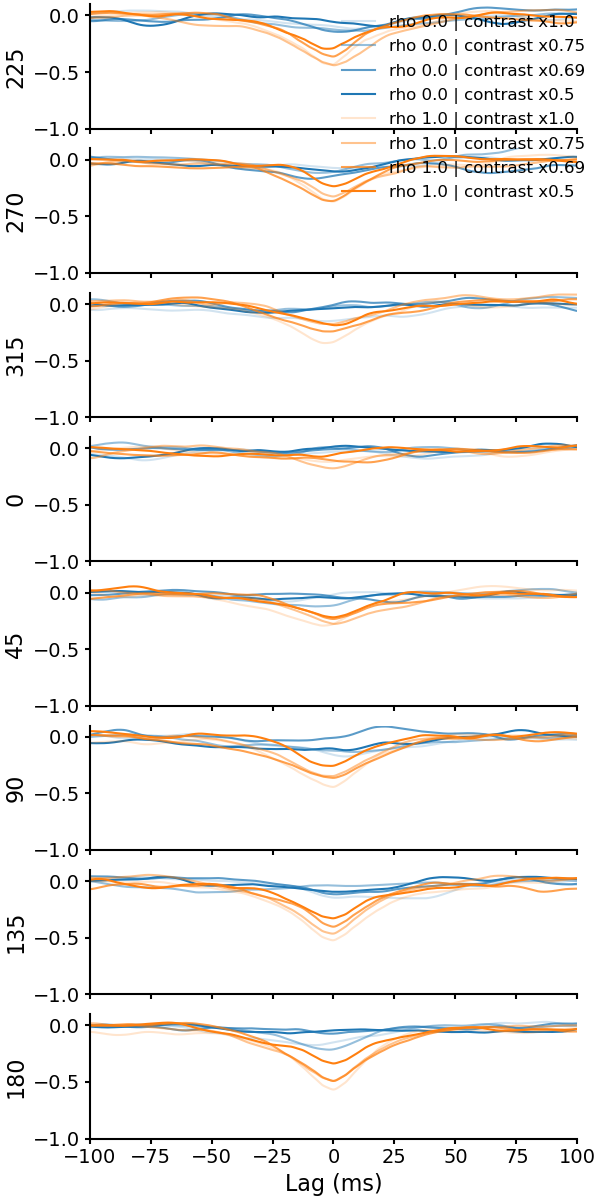

In [19]:
show_steps = step_lbls
# show_rhos = [0.0, 0.8, 0.9, 0.96, 1.0]
show_rhos = rhos

# step_alphas = np.linspace(0.2, 1, len(show_steps))
step_alphas = {s: a for s, a in zip(step_lbls, np.linspace(0.2, 1, len(step_lbls)))}
rho_clrs = {r: "C%i" % i for i, r in enumerate(rhos)}

full_xaxis = np.concatenate([np.flip(res_xaxis[1:] * -1), res_xaxis])
dir_residual_corr_fig, dir_residual_corr_ax = plt.subplots(len(dir_labels), sharex=True, sharey=True, figsize=(6, 12))
for i in range(len(dir_labels)):
    for rho in show_rhos:
        c = rho_clrs[rho]
        for j, s in enumerate(show_steps):
            a = step_alphas[s]
            lbl = ("rho %s | contrast x%s" % (str(rho), str(s))) if not i else None
            xcorr = residual_corr_full_net_avg[s][rho][i]
            dir_residual_corr_ax[i].plot(full_xaxis, xcorr, c=c, alpha=a, label=lbl)
    dir_residual_corr_ax[i].set_ylabel(dir_labels[i], fontsize=16)

dir_residual_corr_ax[-1].set_xlim(-100, 100)
dir_residual_corr_ax[-1].set_ylim(-1, 0.1)
dir_residual_corr_ax[-1].set_xlabel("Lag (ms)", fontsize=16)
dir_residual_corr_fig.legend(frameon=False, fontsize=12)
clean_axes(dir_residual_corr_ax, ticksize=14, spine_width=1.5)
dir_residual_corr_fig.set_layout_engine("compressed")

contrast_lbl = "many" if len(show_steps) > 4 else "_".join(map(str, show_steps)).replace(".", "p")
for ext in [".png", ".svg"]:
    name = "directional_residual_xcorr_%s_contrasts%s" % (contrast_lbl, ext)
    dir_residual_corr_fig.savefig(os.path.join(fig_path, name), bbox_inches="tight")

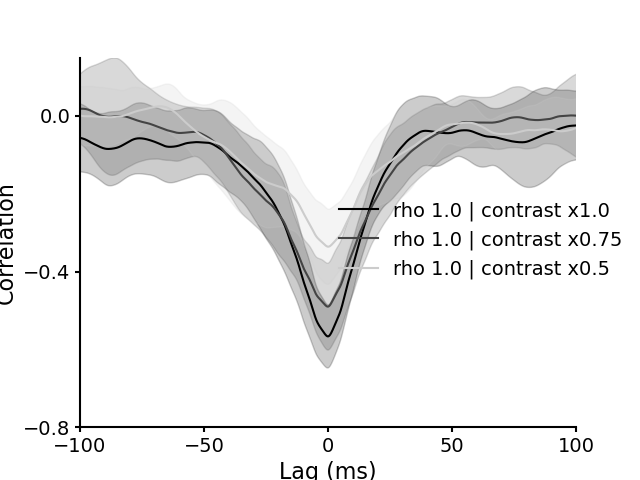

In [20]:
show_steps = step_lbls
show_steps = [1.0, 0.75, 0.5]
# show_rhos = [0.0, 0.8, 0.9, 0.96, 1.0]
show_rhos = rhos
show_rhos = [1.0]

rho_ls = {0.0: "--", 1.0: "-"}
step_clr = {s: "%f" % c for s, c in zip(step_lbls, np.linspace(0.0, 0.8, len(step_lbls)))}

def plot_residual_corr_w_std(ax, step, rho, dir_idx, color=None, ls="-", alpha=0.2, label=None):
    ax.fill_between(
        full_xaxis, 
        residual_corr_full_net_avg[step][rho][dir_idx] + residual_corr_full_net_std[step][rho][dir_idx], 
        residual_corr_full_net_avg[step][rho][dir_idx] - residual_corr_full_net_std[step][rho][dir_idx], 
        alpha=alpha,
        ls=ls,
        **({"color": color} if color is not None else {}),
    )
    ax.plot(full_xaxis, residual_corr_full_net_avg[step][rho][dir_idx], c=color, ls=ls, label=label)
    
null_residual_corr_fig, null_residual_corr_ax = plt.subplots(1)
for rho in show_rhos:
    ls = rho_ls[rho]
    for j, s in enumerate(show_steps):
        c = step_clr[s]
        lbl = "rho %s | contrast x%s" % (str(rho), str(s)) 
        plot_residual_corr_w_std(null_residual_corr_ax, s, rho, null_idx, color=c, ls=ls, label=lbl)
    
null_residual_corr_ax.set_xlim(-100, 100)
null_residual_corr_ax.set_ylim(-0.8, 0.15)
null_residual_corr_ax.set_xticks([-100, -50, 0, 50, 100])
null_residual_corr_ax.set_yticks([-0.8, -0.4, 0.])
null_residual_corr_ax.set_xlabel("Lag (ms)", fontsize=16)
null_residual_corr_ax.set_ylabel("Correlation", fontsize=16)
null_residual_corr_fig.legend(frameon=False, fontsize=14, loc="center right")
clean_axes(null_residual_corr_ax, ticksize=14, spine_width=1.5)

for ext in [".png", ".svg"]:
    name = "null_residual_xcorr" + shuffle_lbl + ext 
    null_residual_corr_fig.savefig(os.path.join(fig_path, name), bbox_inches="tight")

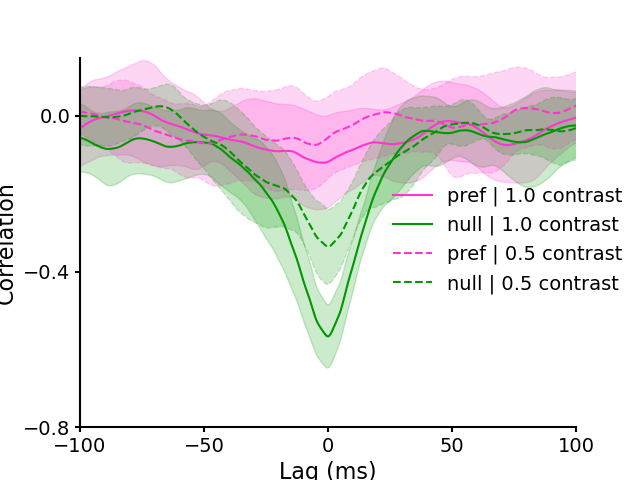

In [21]:
show_steps = [step_lbls[0]]
show_steps = [step_lbls[0], step_lbls[-1]]

step_ls = {s: ls for s, ls in zip(show_steps, ["-", "--", "-."])}

step = 1.0
rho = 1
# rho = 0.96
def plot_pn_residual_corr(ax, show_steps, incl_lbl=True):
    for step in show_steps:
        lbl = "%s contrast" % str(step)
        plot_residual_corr_w_std(
            ax, step, rho, pref_idx, color=bmb_magenta, ls=step_ls[step],
            label=("pref | %s" % lbl) if incl_lbl else None)
        plot_residual_corr_w_std(
            ax, step, rho, null_idx, color=bmb_green, ls=step_ls[step],
            label=("null | %s" % lbl) if incl_lbl else None)
    
pn_residual_corr_fig, pn_residual_corr_ax = plt.subplots(1)
plot_pn_residual_corr(pn_residual_corr_ax, show_steps)
pn_residual_corr_ax.set_xlim(-100, 100)
pn_residual_corr_ax.set_ylim(-0.8, 0.15)
pn_residual_corr_ax.set_xticks([-100, -50, 0, 50, 100])
pn_residual_corr_ax.set_yticks([-0.8, -0.4, 0.])
pn_residual_corr_ax.set_xlabel("Lag (ms)", fontsize=16)
pn_residual_corr_ax.set_ylabel("Correlation", fontsize=16)
pn_residual_corr_fig.legend(frameon=False, fontsize=14, loc="center right")
clean_axes(pn_residual_corr_ax, ticksize=14, spine_width=1.5)

contrast_lbl = "many" if len(show_steps) > 4 else "_".join(map(str, show_steps)).replace(".", "p")
rho_lbl = str(rho).replace(".", "p")
for ext in [".png", ".svg"]:
    name = "pref_null_residual_xcorr_%s_contrasts_rho%s%s%s" % (contrast_lbl, rho_lbl, shuffle_lbl, ext) 
    pn_residual_corr_fig.savefig(os.path.join(fig_path, name), bbox_inches="tight")

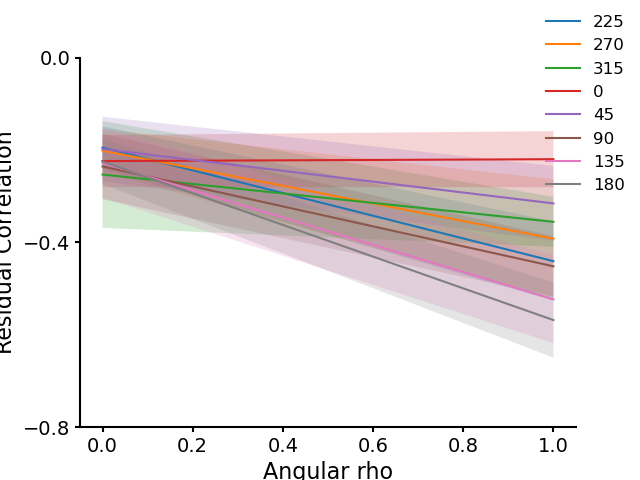

In [22]:
show_step = step_lbls[0]
show_stds = True
show_dirs = dir_labels
# show_dirs = [0, 90, 180]
rho_vs_corr_fig, rho_vs_corr_ax = plt.subplots(1)

for angle in show_dirs:
    i = np.argwhere(dir_labels == angle)[0][0]
    corrs = np.array([residual_corr_full_peak_net_avg[show_step][r][i] for r in rhos])
    if show_stds:
        corr_stds = np.array([residual_corr_full_peak_net_std[show_step][r][i] for r in rhos])
        rho_vs_corr_ax.fill_between(rhos, corrs + corr_stds, corrs - corr_stds, alpha=0.2)
    rho_vs_corr_ax.plot(rhos, corrs, label=dir_labels[i])

min_y = -0.8
rho_vs_corr_ax.set_ylim(min_y, 0)
rho_vs_corr_ax.set_yticks([min_y, min_y / 2, 0.])
rho_vs_corr_ax.set_xlabel("Angular rho", fontsize=16)
rho_vs_corr_ax.set_ylabel("Residual Correlation", fontsize=16)
rho_vs_corr_fig.legend(frameon=False, fontsize=12)
clean_axes(rho_vs_corr_ax, ticksize=14, spine_width=1.5)

step_lbl = str(step).replace(".", "p")
for ext in [".png", ".svg"]:
    name = "rho_vs_residual_xcorr_contrast%s%s%s" % (step_lbl, shuffle_lbl, ext)
    rho_vs_corr_fig.savefig(os.path.join(fig_path, name), bbox_inches="tight")

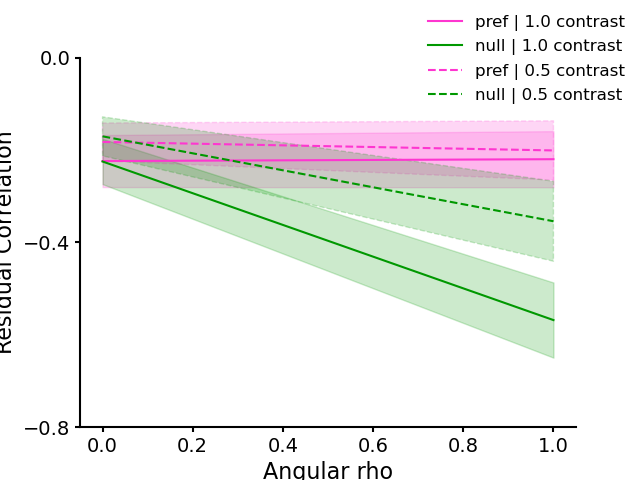

In [23]:
show_steps = [step_lbls[0]]
show_steps = [step_lbls[0], step_lbls[-1]]

step_ls = {s: ls for s, ls in zip(show_steps, ["-", "--", "-."])}

pref_corrs = {s: np.array([residual_corr_full_peak_net_avg[s][r][pref_idx] for r in rhos]) for s in show_steps}
pref_corr_stds = {s: np.array([residual_corr_full_peak_net_std[s][r][pref_idx] for r in rhos]) for s in show_steps}
null_corrs = {s: np.array([residual_corr_full_peak_net_avg[s][r][null_idx] for r in rhos]) for s in show_steps}
null_corr_stds = {s: np.array([residual_corr_full_peak_net_std[s][r][null_idx] for r in rhos]) for s in show_steps}

def plot_pn_rho_vs_corr(ax, show_steps):
    for s in show_steps:
        ax.fill_between(
            rhos, 
            pref_corrs[s] + pref_corr_stds[s], 
            pref_corrs[s] - pref_corr_stds[s], 
            color=bmb_magenta,
            alpha=0.2,
            ls=step_ls[s],
        )
        ax.plot(rhos, pref_corrs[s], c=bmb_magenta, ls=step_ls[s],label="pref | %s contrast" % str(s))
        ax.fill_between(
            rhos, 
            null_corrs[s] + null_corr_stds[s], 
            null_corrs[s] - null_corr_stds[s], 
            color=bmb_green,
            alpha=0.2,
            ls=step_ls[s],
        )
        ax.plot(rhos, null_corrs[s], c=bmb_green, ls=step_ls[s], label="null | %s contrast" % str(s))

pn_rho_vs_corr_fig, pn_rho_vs_corr_ax = plt.subplots(1)
plot_pn_rho_vs_corr(pn_rho_vs_corr_ax, show_steps)

min_y = -0.8
pn_rho_vs_corr_ax.set_ylim(min_y, 0)
pn_rho_vs_corr_ax.set_yticks([min_y, min_y / 2, 0.])
pn_rho_vs_corr_ax.set_xlabel("Angular rho", fontsize=16)
pn_rho_vs_corr_ax.set_ylabel("Residual Correlation", fontsize=16)
pn_rho_vs_corr_fig.legend(frameon=False, fontsize=12)
clean_axes(pn_rho_vs_corr_ax, ticksize=14, spine_width=1.5)

contrast_lbl = "many" if len(show_steps) > 4 else "_".join(map(str, show_steps)).replace(".", "p")
for ext in [".png", ".svg"]:
    name = os.path.join(
        fig_path, "pref_null_rho_vs_residual_xcorr_%s_contrasts%s%s" % (contrast_lbl, shuffle_lbl, ext))
    pn_rho_vs_corr_fig.savefig(name, bbox_inches="tight")

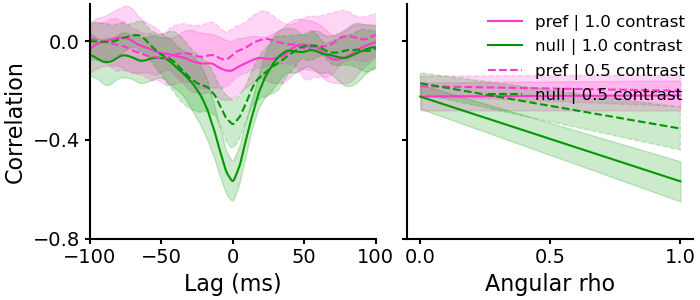

In [24]:
show_steps = [step_lbls[0]]
show_steps = [step_lbls[0], step_lbls[-1]]

pn_xcorr_and_rho_vs_corr_fig, pn_xcorr_and_rho_vs_corr_ax = plt.subplots(
    1, 2, 
    sharey=True, 
    # gridspec_kw={"width_ratios": [0.6, 0.4]},
    gridspec_kw={"width_ratios": [0.5, 0.5]},
    figsize=(7, 3),
)

plot_pn_residual_corr(pn_xcorr_and_rho_vs_corr_ax[0], show_steps, incl_lbl=False)
plot_pn_rho_vs_corr(pn_xcorr_and_rho_vs_corr_ax[1], show_steps)

min_y = -0.8
pn_xcorr_and_rho_vs_corr_ax[0].set_xlim(-100, 100)
pn_xcorr_and_rho_vs_corr_ax[0].set_xticks([-100, -50, 0, 50, 100])
pn_xcorr_and_rho_vs_corr_ax[0].set_ylim(min_y, 0.15)
pn_xcorr_and_rho_vs_corr_ax[0].set_yticks([min_y, min_y / 2, 0.])
pn_xcorr_and_rho_vs_corr_ax[0].set_xlabel("Lag (ms)", fontsize=16)
pn_xcorr_and_rho_vs_corr_ax[0].set_ylabel("Correlation", fontsize=16)
pn_xcorr_and_rho_vs_corr_ax[1].set_xticks([0, 0.5, 1])
pn_xcorr_and_rho_vs_corr_ax[1].set_xlabel("Angular rho", fontsize=16)
pn_xcorr_and_rho_vs_corr_fig.legend(frameon=False, fontsize=12)
clean_axes(pn_xcorr_and_rho_vs_corr_ax, ticksize=14, spine_width=1.5)
pn_xcorr_and_rho_vs_corr_fig.set_layout_engine("compressed")

contrast_lbl = "many" if len(show_steps) > 4 else "_".join(map(str, show_steps)).replace(".", "p")
for ext in [".png", ".svg"]:
    name = os.path.join(
        fig_path, "pref_null_lag_and_rho_vs_residual_xcorr_%s_contrast%s%s" % (contrast_lbl, shuffle_lbl, ext))
    pn_xcorr_and_rho_vs_corr_fig.savefig(name, bbox_inches="tight")

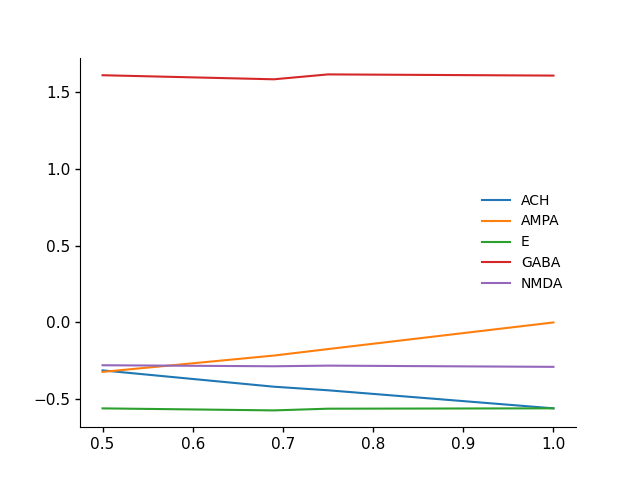

In [25]:
net_avg_pk_v_ctr = {
    t: np.array([vc_net_avg_peaks[s][1.0][t][null_idx] for s in step_lbls])
    for t in transmitters
}

pk_vs_contrast_fig, pk_vs_contrast_ax = plt.subplots(1)
for trans, pks in net_avg_pk_v_ctr.items():
    pk_vs_contrast_ax.plot(step_lbls, pks, label=trans)

pk_vs_contrast_ax.legend(frameon=False)
clean_axes(pk_vs_contrast_ax)

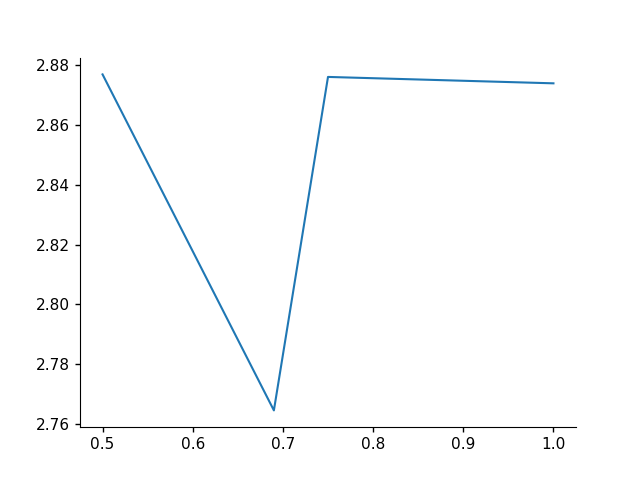

In [26]:
pk_ei_ratio_vs_contrast_fig, pk_ei_ratio_vs_contrast_ax = plt.subplots(1)
ei_ratio = -net_avg_pk_v_ctr["E"] / net_avg_pk_v_ctr["GABA"]
ei_ratio =  net_avg_pk_v_ctr["GABA"] / -net_avg_pk_v_ctr["E"]
pk_ei_ratio_vs_contrast_ax.plot(step_lbls, ei_ratio)

clean_axes(pk_ei_ratio_vs_contrast_ax)

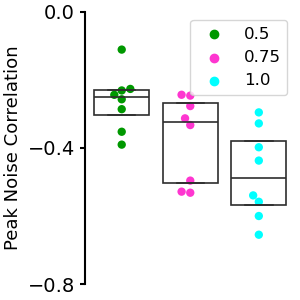

In [44]:
xcorr_net_peaks = {
    s: {
        r: np.stack([residual_corr_full_peak_trial_avg[s][r][i] for i in idxs], axis=0)
        for r in rhos
    }
    for s in step_lbls
}

rho = 1.0
display_steps = step_lbls
display_steps = [0.5, 0.75, 1.0]

palette = [bmb_green, bmb_magenta, "cyan"]

swarm_kw = dict(palette=palette, size=6, zorder=0.5, alpha=1)
box_kw = dict(palette=palette, linewidth=1.2, whis=0, fliersize=0, boxprops=dict(facecolor='None'))
pk_corr_swarm_fig, pk_corr_swarm_ax = plt.subplots(1, figsize=(3, 3))

pk_df = pd.DataFrame.from_dict({s: xcorr_net_peaks[s][rho][null_idx] for s in display_steps})
sns.boxplot(pk_df, ax=pk_corr_swarm_ax, **box_kw)
sns.swarmplot(pk_df, ax=pk_corr_swarm_ax, **swarm_kw)
pk_corr_swarm_ax.set_ylabel("Peak Noise Correlation", fontsize=13)

for s, c in zip(display_steps, palette):
    pk_corr_swarm_ax.scatter([], [], c=c, label=s)
    
ymax = -0.8

pk_corr_swarm_ax.set_yticks([0, ymax / 2, ymax])
# pk_corr_swarm_ax.set_yticklabels([0, None, ymax])

pk_corr_swarm_ax.legend(frameon=True, fontsize=12, loc="upper right")
clean_axes(pk_corr_swarm_ax, ticksize=14, spine_width=1.5, remove_spines=["top", "right", "bottom"])
pk_corr_swarm_fig.set_layout_engine("compressed")

steps_lbl = "_".join(map(str, display_steps))
rho_lbl = str(rho)
for ext in exts:
    pk_corr_swarm_fig.savefig(
        os.path.join(fig_path, "pk_null_corr_swarmplot_steps%s_rho%s%s" % (
            steps_lbl, rho_lbl, ext)), bbox_inches="tight")